# Proyecto Individual 02 de Henry por Guillermo Fernandez

#### Importar librerías necesarias

In [1]:
# Librería para trabajar con los datasets
import pandas as pd
import numpy as np

# Módulo para trabajar con rutas de archivo
from pathlib import Path

# Librería para identificar encondings
import chardet

# Módulos para realizar modelos de Machine Learning
from sklearn import preprocessing as pp
from sklearn.tree import DecisionTreeClassifier

# Módulo para evaluar chi2
from scipy import stats

# Módulos para separar los datasets
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

# Módulos para medir los modelos
from sklearn import metrics as met

# Librerías para visualizar gráficos
import seaborn as sns
import matplotlib.pyplot as plt

#### Crear una función para importar los datasets

In [2]:
# Para importar archivos csv, detectando encoding
def upload(filepath):
    with open(filepath, 'rb') as file:
        result = chardet.detect(file.read())
        DF = pd.read_csv(filepath, encoding=result['encoding'])
    return DF

#### Cargar y explorar el dataset

In [3]:
# Cargamos ambos datasets
Train_df = upload(r'C:\Users\eugen\Documents\Guille\Bootcamp\PI02_Datathon\Datasets\hospitalizaciones_train.csv')
Test_df = upload(r'C:\Users\eugen\Documents\Guille\Bootcamp\PI02_Datathon\Datasets\hospitalizaciones_test.csv')

In [4]:
# Aplicamos una función para renombrar las columnas, reemplazando espacios por guión bajo, y aplicando minúsculas
Train_df.rename(lambda x : x.lower().strip().replace(' ','_'), axis = 1, inplace = True)
Test_df.rename(lambda x : x.lower().strip().replace(' ','_'), axis = 1, inplace = True)

In [5]:
# Guardamos el original y trabajamos con una copia
Train_original = Train_df.copy()
Test_original = Test_df.copy()

In [6]:
# Tomamos una fila al azar para analizarlo
Train_df.sample(1)

,available_extra_rooms_in_hospital,department,ward_facility_code,doctor_name,staff_available,patientid,age,gender,type_of_admission,severity_of_illness,health_conditions,visitors_with_patient,insurance,admission_deposit,stay_(in_days)
75460,6,gynecology,D,Dr Olivia,0,43238,31-40,Female,Trauma,Moderate,None,4,Yes,4432.795433,8


In [7]:
Test_df.sample(1)

,available_extra_rooms_in_hospital,department,ward_facility_code,doctor_name,staff_available,patientid,age,gender,type_of_admission,severity_of_illness,health_conditions,visitors_with_patient,insurance,admission_deposit
6485,2,radiotherapy,A,Dr Sam,5,41347,61-70,Male,Trauma,Moderate,High Blood Pressure,2,Yes,4787.27663


In [8]:
# Evaluamos información del dataset, como Dtype y nulos
Train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410000 entries, 0 to 409999
Data columns (total 15 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   available_extra_rooms_in_hospital  410000 non-null  int64  
 1   department                         410000 non-null  object 
 2   ward_facility_code                 410000 non-null  object 
 3   doctor_name                        410000 non-null  object 
 4   staff_available                    410000 non-null  int64  
 5   patientid                          410000 non-null  int64  
 6   age                                410000 non-null  object 
 7   gender                             410000 non-null  object 
 8   type_of_admission                  410000 non-null  object 
 9   severity_of_illness                410000 non-null  object 
 10  health_conditions                  410000 non-null  object 
 11  visitors_with_patient              4100

In [9]:
Test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   available_extra_rooms_in_hospital  90000 non-null  int64  
 1   department                         90000 non-null  object 
 2   ward_facility_code                 90000 non-null  object 
 3   doctor_name                        90000 non-null  object 
 4   staff_available                    90000 non-null  int64  
 5   patientid                          90000 non-null  int64  
 6   age                                90000 non-null  object 
 7   gender                             90000 non-null  object 
 8   type_of_admission                  90000 non-null  object 
 9   severity_of_illness                90000 non-null  object 
 10  health_conditions                  90000 non-null  object 
 11  visitors_with_patient              90000 non-null  int

### Data Preprocessing

#### Feature relevante

In [10]:
# Eliminamos los datos duplicados
Train_df.drop_duplicates();
Test_df.drop_duplicates();

In [11]:
# Agregamos el feature que nos interesa predecir, si la estadía es prolongada
Train_df['long_stay'] = (Train_df['stay_(in_days)'] > 8)
Train_df['long_stay'].astype(str).replace({False: 0, True: 1})
Train_df['long_stay'] = Train_df['long_stay'].astype(int)
# Dropeamos la columna 'stay_(in_days)' para evitar redundancia
Train_df.drop(columns='stay_(in_days)', inplace=True);

In [12]:
Train_df.sample(1)

,available_extra_rooms_in_hospital,department,ward_facility_code,doctor_name,staff_available,patientid,age,gender,type_of_admission,severity_of_illness,health_conditions,visitors_with_patient,insurance,admission_deposit,long_stay
386340,4,gynecology,F,Dr Sophia,10,94190,31-40,Female,Trauma,Moderate,Heart disease,4,Yes,4185.49919,0


In [13]:
# Revisamos la cantidad de valores del feature agregado
Train_df.long_stay.value_counts()

1    255416
0    154584
Name: long_stay, dtype: int64

### Analizar correlación de acuerdo al P valor

In [14]:
# Tomamos los nombres de todas las columnas
list(Train_df.columns)[:-1];

In [15]:
# Evaluamos la correlación con la feature seleccionada de cada otra feature (no numérica)
for elem in list(Train_df.columns)[:-1]:
    P_valor = stats.chi2_contingency(np.array(pd.crosstab(Train_df[elem], Train_df.long_stay)))[1]
    print(f'{elem}: {P_valor}')

available_extra_rooms_in_hospital: 0.0
department: 0.0
ward_facility_code: 0.0
doctor_name: 0.0
staff_available: 0.027185032657605284
patientid: 0.29157056421547367
age: 0.0
gender: 0.0
type_of_admission: 1.6947748596830503e-21
severity_of_illness: 2.875013724138087e-130
health_conditions: 5.6584831831517945e-09
visitors_with_patient: 0.0
insurance: 0.4988221951889673
admission_deposit: 0.49327701140734725


In [16]:
# Evaluamos la correlación con features numéricas
Train_df.corr()

,available_extra_rooms_in_hospital,staff_available,patientid,visitors_with_patient,admission_deposit,long_stay
available_extra_rooms_in_hospital,1.000000,-0.003064,-0.005426,0.071073,-0.050775,0.053894
staff_available,-0.003064,1.000000,-0.000350,0.001444,0.000816,0.002883
patientid,-0.005426,-0.000350,1.000000,-0.006393,0.011602,-0.000532
visitors_with_patient,0.071073,0.001444,-0.006393,1.000000,-0.069566,-0.009529
admission_deposit,-0.050775,0.000816,0.011602,-0.069566,1.000000,-0.016650
long_stay,0.053894,0.002883,-0.000532,-0.009529,-0.016650,1.000000


### Tratamiento de features

###### Se eliminan columnas que no tienen significado numérico y presentan ninguna correlación

In [17]:
Train_df.drop(columns=['patientid', 'insurance'], inplace=True)
Test_df.drop(columns=['patientid', 'insurance'], inplace=True)

In [18]:
# Revisamos que las features en ambos datasets sean iguales
for elem in list(Test_df.columns):
    print(f'{elem}')
    unicos_train, unicos_test = Train_df[elem].sort_values().unique(), Test_df[elem].sort_values().unique()
    print(f'        Train: {len(unicos_train)} {unicos_train}')
    print(f'        Test:  {len(unicos_test)} {unicos_test}')
    print(f'Son iguales: {unicos_test.all() == unicos_train.all()}')

available_extra_rooms_in_hospital
        Train: 18 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 20 21 24]
        Test:  18 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 20 21 24]
Son iguales: True
department
        Train: 5 ['TB & Chest disease' 'anesthesia' 'gynecology' 'radiotherapy' 'surgery']
        Test:  5 ['TB & Chest disease' 'anesthesia' 'gynecology' 'radiotherapy' 'surgery']
Son iguales: True
ward_facility_code
        Train: 6 ['A' 'B' 'C' 'D' 'E' 'F']
        Test:  6 ['A' 'B' 'C' 'D' 'E' 'F']
Son iguales: True
doctor_name
        Train: 9 ['Dr Isaac' 'Dr John' 'Dr Mark' 'Dr Nathan' 'Dr Olivia' 'Dr Sam'
 'Dr Sarah' 'Dr Simon' 'Dr Sophia']
        Test:  9 ['Dr Isaac' 'Dr John' 'Dr Mark' 'Dr Nathan' 'Dr Olivia' 'Dr Sam'
 'Dr Sarah' 'Dr Simon' 'Dr Sophia']
Son iguales: True
staff_available
        Train: 11 [ 0  1  2  3  4  5  6  7  8  9 10]
        Test:  11 [ 0  1  2  3  4  5  6  7  8  9 10]
Son iguales: True
age
        Train: 10 ['0-10' '11-20' '21-30' '31-40' '41-50

#### Recategorizar las variables

In [19]:
# Utilizamos OneHotEncoder para modificar variables categóricas
OHE = pp.OneHotEncoder(categories='auto')
# Aplicamos a las columnas categóricas
OHE_df = OHE.fit_transform(Train_df[['department', 'ward_facility_code', 'doctor_name', 'gender',
                                     'type_of_admission', 'health_conditions']]).toarray()

In [20]:
# Transformamos y unimos al DF original
OHE_df = pd.DataFrame(OHE_df, columns=OHE.get_feature_names_out())
Train_df = pd.concat([Train_df, OHE_df], axis=1)

In [21]:
# Se eliminan las columnas que fueron transformadas
Train_df.drop(columns = ['department', 'ward_facility_code', 'doctor_name', 'gender',
                         'type_of_admission', 'health_conditions'], inplace = True)

In [22]:
# Ahora hacemos similar pero con LabelEncoder
LE = pp.LabelEncoder()
Train_df.age = LE.fit_transform(Train_df.age)
Train_df.severity_of_illness = LE.fit_transform(Train_df.severity_of_illness)

In [23]:
Train_df.sample(1)

,available_extra_rooms_in_hospital,staff_available,age,severity_of_illness,visitors_with_patient,admission_deposit,long_stay,department_TB & Chest disease,department_anesthesia,department_gynecology,...,gender_Other,type_of_admission_Emergency,type_of_admission_Trauma,type_of_admission_Urgent,health_conditions_Asthama,health_conditions_Diabetes,health_conditions_Heart disease,health_conditions_High Blood Pressure,health_conditions_None,health_conditions_Other
82085,4,4,3,2,10,4060.197564,0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [24]:
# Repetimos para el set de testeo
OHE_df = OHE.fit_transform(Test_df[['department', 'ward_facility_code', 'doctor_name', 'gender',
                                     'type_of_admission', 'health_conditions']]).toarray()
OHE_df = pd.DataFrame(OHE_df, columns=OHE.get_feature_names_out())
Test_df = pd.concat([Test_df, OHE_df], axis=1)
Test_df.drop(columns = ['department', 'ward_facility_code', 'doctor_name', 'gender',
                         'type_of_admission', 'health_conditions'], inplace = True)
Test_df.age = LE.fit_transform(Test_df.age)
Test_df.severity_of_illness = LE.fit_transform(Test_df.severity_of_illness)


## Modelado

### Árbol de desición

In [39]:
# Consideramos un árbol de desición para realizar la predicción
X = Train_df.drop(columns=['long_stay'])
y = Train_df.long_stay

In [26]:
# Realizamos una iteración para evaluar la profundidad óptima del árbol
tree_train_scores_mean = []
tree_train_scores_std = []
# Iniciamos listas para guardar los valores
tree_test_scores_mean = []
tree_test_scores_std = []
# Consideramos 25 como profundidad máxima
profundidades = np.arange(1,25,1)

for profundidad in profundidades:
    # Instanciamos el arbol
    clf = DecisionTreeClassifier(max_depth=profundidad,criterion="entropy")
    # Realizamos tres pruebas gracias al metodo cross_validate
    tree_scores = cross_validate(clf, X, y, cv=3, return_train_score=True, n_jobs = -1)
    # Guardamos los valores tanto del entrenamiento como del test
    tree_train_scores_mean.append(tree_scores['train_score'].mean())
    tree_train_scores_std.append(tree_scores['train_score'].std())
    
    tree_test_scores_mean.append(tree_scores['test_score'].mean())
    tree_test_scores_std.append(tree_scores['test_score'].std())
    print(f'Arbol nivel {profundidad} listo!')
#Transformamos los valores para poder graficarlos
tree_train_scores_mean = np.array(tree_train_scores_mean)
tree_train_scores_std = np.array(tree_train_scores_std)
tree_test_scores_mean = np.array(tree_test_scores_mean)
tree_test_scores_std = np.array(tree_test_scores_std)

Arbol nivel 1 listo!
Arbol nivel 2 listo!
Arbol nivel 3 listo!
Arbol nivel 4 listo!
Arbol nivel 5 listo!
Arbol nivel 6 listo!
Arbol nivel 7 listo!
Arbol nivel 8 listo!
Arbol nivel 9 listo!
Arbol nivel 10 listo!
Arbol nivel 11 listo!
Arbol nivel 12 listo!
Arbol nivel 13 listo!
Arbol nivel 14 listo!
Arbol nivel 15 listo!
Arbol nivel 16 listo!
Arbol nivel 17 listo!
Arbol nivel 18 listo!
Arbol nivel 19 listo!
Arbol nivel 20 listo!
Arbol nivel 21 listo!
Arbol nivel 22 listo!
Arbol nivel 23 listo!
Arbol nivel 24 listo!


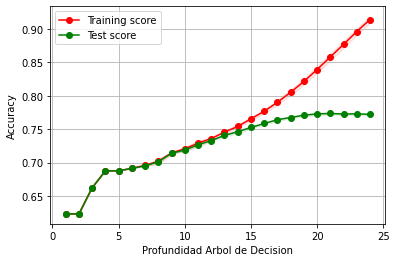

In [27]:
# Ploteamos los resultados
plt.fill_between(profundidades, tree_train_scores_mean - tree_train_scores_std,
                 tree_train_scores_mean + tree_train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(profundidades, tree_test_scores_mean - tree_test_scores_std,
                 tree_test_scores_mean + tree_test_scores_std, alpha=0.1, color="g")

plt.plot(profundidades, tree_train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(profundidades, tree_test_scores_mean, 'o-', color="g",
         label="Test score")

plt.legend()
plt.grid()
plt.ylabel('Accuracy')
plt.xlabel('Profundidad Arbol de Decision')
plt.show()

##### De acuerdo a lo ensayado, tomar la profundidad óptima y medir

In [40]:
clf = DecisionTreeClassifier(max_depth=15,criterion="entropy")
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, y, test_size = 0.25, random_state=21)
clf.fit(X_Train.values, Y_Train.values)
Y_pred = clf.predict(X_Test.values)
print(met.classification_report(Y_Test, Y_pred))

              precision    recall  f1-score   support

           0       0.69      0.63      0.66     38805
           1       0.79      0.83      0.81     63695

    accuracy                           0.75    102500
   macro avg       0.74      0.73      0.73    102500
weighted avg       0.75      0.75      0.75    102500



array([[24453, 14352],
       [10902, 52793]], dtype=int64)

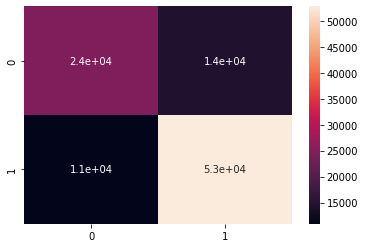

In [41]:
sns.heatmap(met.confusion_matrix(Y_Test, Y_pred),annot=True)
met.confusion_matrix(Y_Test, Y_pred)

## Predicción

In [46]:
# Realizamos la predicción para el dataset Test
X = Test_df
y_pred = clf.predict(X.values)

In [47]:
# Evaluamos la cantidad de datos
y_pred.shape

(90000,)

In [48]:
# Asignamos los datos al dataset
Test_df['pred'] = y_pred

In [49]:
# Revisamos los resultados obtenidos
Test_df.sample(5)

,available_extra_rooms_in_hospital,staff_available,age,severity_of_illness,visitors_with_patient,admission_deposit,department_TB & Chest disease,department_anesthesia,department_gynecology,department_radiotherapy,...,type_of_admission_Emergency,type_of_admission_Trauma,type_of_admission_Urgent,health_conditions_Asthama,health_conditions_Diabetes,health_conditions_Heart disease,health_conditions_High Blood Pressure,health_conditions_None,health_conditions_Other,pred
67064,2,9,4,2,2,4890.181097,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
24157,3,2,2,2,2,4390.938217,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
23707,3,7,7,2,2,3872.951447,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
19992,3,4,7,2,2,4476.634400,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
14781,3,7,1,2,4,4149.366961,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1


In [50]:
# Contamos la cantidad de resultados
Test_df.pred.value_counts()

1    59320
0    30680
Name: pred, dtype: int64

In [51]:
# Tomamos únicamente la columna con las predicciones
result = Test_df.pred

In [52]:
# Exportamos la columna a un csv de acuerdo a la consigna del proyecto
result.to_csv(r'C:\Users\eugen\Documents\Guille\Bootcamp\PI02_Datathon\Datasets\fernandezguille.csv', index=False)

## Conclusiones finales

Luego de realizar varias pruebas, con diferentes métodos (dummies, OHE, LE), este modelo fue el que mejor accuracy y recall tuvo, sin tener overfitting.  
Muchas de las columnas tenían una relación con la estadía, como se vió con el P_valor, pero el resultado solo mejora un poco a comparación de realizar el árbol con sólo 3 features.
Al recibir el feedback del modelo, los valores logrados de las métricas son:
+ Accuracy: 0.7512
+ Recall:   0.7847